In [21]:
#Denoising 
import keras
from keras.callbacks import TensorBoard
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

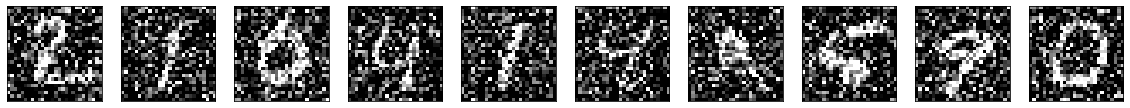

In [11]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 14, 14, 32)        0         
__________

In [16]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 244s 4ms/step - loss: 0.1458 - val_loss: 0.1166
Epoch 2/10
60000/60000 [==============================] - 249s 4ms/step - loss: 0.1140 - val_loss: 0.1096
Epoch 3/10
60000/60000 [==============================] - 230s 4ms/step - loss: 0.1085 - val_loss: 0.1065
Epoch 4/10
60000/60000 [==============================] - 224s 4ms/step - loss: 0.1049 - val_loss: 0.1029
Epoch 5/10
60000/60000 [==============================] - 214s 4ms/step - loss: 0.1028 - val_loss: 0.1011
Epoch 6/10
60000/60000 [==============================] - 234s 4ms/step - loss: 0.1013 - val_loss: 0.0998
Epoch 7/10
60000/60000 [==============================] - 236s 4ms/step - loss: 0.1003 - val_loss: 0.0991
Epoch 8/10
60000/60000 [==============================] - 225s 4ms/step - loss: 0.0995 - val_loss: 0.0983
Epoch 9/10
60000/60000 [==============================] - 216s 4ms/step - loss: 0.0989 - val_loss: 0.0

In [17]:
def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

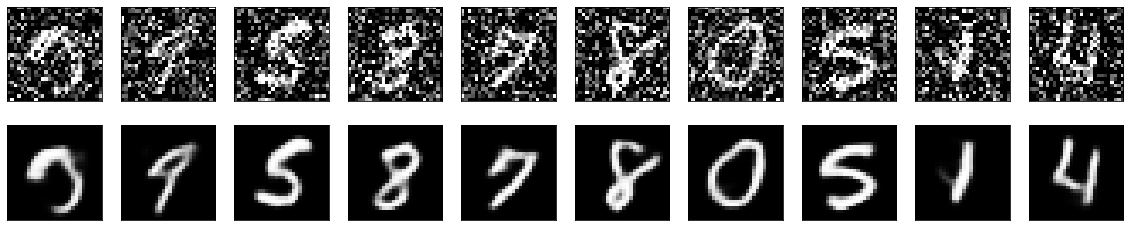

In [20]:
#Let's now predict on the noisy data and display the results of our autoencoder.
#Notice how the autoencoder is removing the noise from the input images.
predictions = autoencoder.predict(x_test_noisy)
display(x_test_noisy, predictions)